# Домашнее задание №1 "Сегментация и детекция объектов"

Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.


## Подключение библиотек

In [ ]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


In [ ]:
print(cv2.__version__)

4.7.0


## Загрузка данных

In [ ]:
!wget https://raw.githubusercontent.com/a4tunado/lectures/master/002/data/digit/test.csv

--2023-07-04 13:32:30--  https://raw.githubusercontent.com/a4tunado/lectures/master/002/data/digit/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51118296 (49M) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>]  48.75M   258MB/s    in 0.2s    

2023-07-04 13:32:32 (258 MB/s) - ‘test.csv’ saved [51118296/51118296]



In [ ]:
!wget https://raw.githubusercontent.com/a4tunado/lectures/master/002/data/digit/train.csv

--2023-07-04 13:32:35--  https://raw.githubusercontent.com/a4tunado/lectures/master/002/data/digit/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76775041 (73M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  73.22M   290MB/s    in 0.3s    

2023-07-04 13:32:38 (290 MB/s) - ‘train.csv’ saved [76775041/76775041]



In [ ]:
train = np.loadtxt('/content/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('/content/test.csv', delimiter=',', skiprows=1)

In [ ]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

### Визуализация картинок из датасета

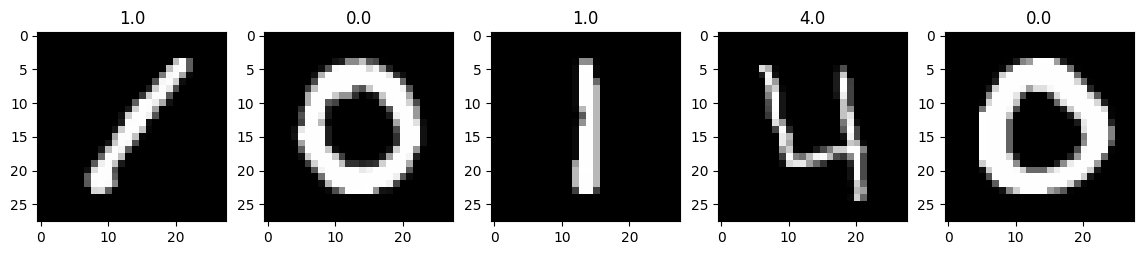

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Построение гистограммы градиентов (HOG) для классификации (подготовка данных для обучения)

### Задаем параметры для вычисления HOG дескриптора

In [ ]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (14,14)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels)

### Вычисление дескриптора

In [ ]:
train_desc = np.zeros((len(train_img), 144))
for i in range(len(train_img)):
    descriptor = hog.compute(np.uint8(train_img[i]))
    train_desc[i] = descriptor

In [ ]:
test_desc = np.zeros((len(test_img), 144))
for i in range(len(test_img)):
    descriptor = hog.compute(np.uint8(test_img[i]))
    test_desc[i] = descriptor

### Нормализация полученных векторов

In [ ]:
train_desc = train_desc / np.linalg.norm(train_desc, axis=1)[:, None]
test_desc = test_desc / np.linalg.norm(test_desc, axis=1)[:, None]

## Построение и обучение модели DecisionTreeClassifier

In [ ]:
# Разбиение массива train на обучающую и валидационные выборки
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(train_label, train_desc, test_size=0.2, random_state=42)

In [ ]:
params = {'max_depth': list( range(1, 20) ),
            'min_samples_leaf' : [3000, 200, 100, 50, 10, 5]}

### Поиск лучших параметров с помощью GridSearch

In [ ]:
gs = GridSearchCV( DecisionTreeClassifier(), param_grid = params, scoring = 'accuracy', return_train_score = False )

In [ ]:
gs.fit( x_train, y_train )

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'min_samples_leaf': [3000, 200, 100, 50, 10, 5]},
             scoring='accuracy')

In [ ]:
gs.cv_results_

{'mean_fit_time': array([0.52459116, 0.53599277, 0.54212303, 0.67247305, 0.5342948 ,
        0.53417635, 1.0071887 , 1.10606394, 1.03221006, 1.18372049,
        1.03454394, 1.18368516, 1.30241957, 1.66933484, 1.58799071,
        1.5849062 , 1.6755724 , 1.52357445, 1.69507751, 3.05356455,
        2.12511759, 2.13792953, 2.1517982 , 2.16854453, 1.66374197,
        2.52398272, 2.54721084, 2.57786508, 2.65464468, 2.56974049,
        1.79808922, 2.86592431, 2.93368301, 3.26086702, 2.98148255,
        2.98991847, 1.8328546 , 3.17577324, 3.28092265, 3.48509073,
        3.38270793, 3.3900022 , 1.79004035, 3.43552008, 3.70942106,
        3.69631095, 3.94255047, 3.78182807, 1.79887309, 3.77160082,
        3.81651163, 4.13750458, 4.08255835, 4.26478729, 1.79466152,
        3.76307993, 4.17948427, 4.38733397, 4.41310124, 4.58610525,
        1.7874166 , 3.83623691, 5.26874557, 5.58049035, 5.68433609,
        5.47344303, 1.79592996, 4.17559371, 4.94446411, 5.32474523,
        5.92651348, 5.21566081,

In [ ]:
gs.best_params_

{'max_depth': 16, 'min_samples_leaf': 5}

### Обучение с найденными лучшими параметрами

In [ ]:
cross_val_score(DecisionTreeClassifier( max_depth = 16, min_samples_leaf =  5), x_train, y_train, cv = 5, scoring = 'accuracy')

array([0.85863095, 0.86592262, 0.8610119 , 0.87217262, 0.86264881])

In [ ]:
model = DecisionTreeClassifier(max_depth = 16,  min_samples_leaf =  5, random_state = 42)

In [ ]:
model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=16, min_samples_leaf=5, random_state=42)

In [ ]:
model.score(x_val, y_val)

0.866904761904762

### classification_report

In [ ]:
predict= model.predict(x_val)
print(classification_report(y_val, predict))

              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90       816
         1.0       0.94      0.95      0.94       909
         2.0       0.84      0.85      0.84       846
         3.0       0.85      0.85      0.85       937
         4.0       0.87      0.87      0.87       839
         5.0       0.86      0.86      0.86       702
         6.0       0.91      0.90      0.90       785
         7.0       0.84      0.85      0.85       893
         8.0       0.82      0.80      0.81       835
         9.0       0.85      0.83      0.84       838

    accuracy                           0.87      8400
   macro avg       0.87      0.87      0.87      8400
weighted avg       0.87      0.87      0.87      8400



### Предсказание для тестового массива

In [ ]:
x_test = test_desc

In [ ]:
predict_test = model.predict(x_test)
# print(classification_report(y_val, predict))

In [ ]:
predict_test

array([3., 0., 9., ..., 3., 9., 2.])

### Сохранение результатов в csv файл

In [ ]:
import pandas as pd

In [ ]:
submit = pd.DataFrame()
submit['ImageId'] = 0
submit['Label'] = predict_test
submit.index += 1
submit['ImageId'] = submit.index
submit['Label'] = submit['Label'].astype('int64')

In [ ]:
submit.to_csv('submitt.csv', index = False)

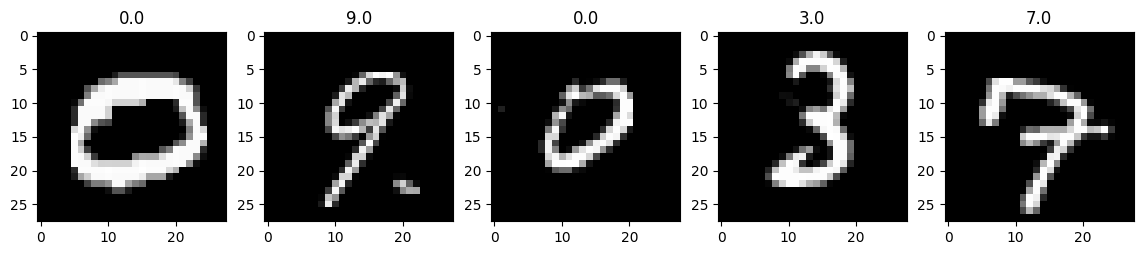

In [ ]:
# отрисовка предсказанных значений
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[1:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % predict_test[i]);
